# Importación de Librerías Necesarias

In [1]:
# CNN
import os
import keras
import scipy
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical
import random, shutil
from keras.models import Sequential
from keras.layers import (
    Dropout,
    Conv2D,
    Flatten,
    Dense,
    MaxPooling2D,
    BatchNormalization,
)
from keras.models import load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image
from PIL import Image


# Generador de imágenes para Validación

In [3]:
def generator(
    dir=r"C:\Users\acer.LAPTOP-5D7SPG9D\Desktop\Isaac\YachayTech\10mo Semestre\Neuronal Networks\Project_NN\dataset_new",
    gen=ImageDataGenerator(rescale=1.0 / 255),
    shuffle=True,
    batch_size=1,
    target_size=(24, 24),
    class_mode="categorical",
):

    return gen.flow_from_directory(
        dir,
        batch_size=batch_size,
        shuffle=shuffle,
        color_mode="grayscale",
        class_mode=class_mode,
        target_size=target_size,
    )

# Generador de Imágenes con Aumento de Datos (Entrenamiento)

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10, # Rango de rotación en grados
    zoom_range=0.1, # Rango de zoom aleatorio
    width_shift_range=0.1, # Desplazamiento horizontal aleatorio
    height_shift_range=0.1, # Desplazamiento vertical aleatorio
    shear_range=0.1, # Corte aleatorio
    horizontal_flip=True, # Volteo horizontal aleatorio
    fill_mode='nearest' # Modo de llenado de píxeles
    )

# Verificar CUDA para uso de GPU

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import multiprocessing
print("Número de núcleos de CPU disponibles: ", multiprocessing.cpu_count())

Num GPUs Available:  1
Número de núcleos de CPU disponibles:  12


# Carga de Imágenes con Aumento de Datos

In [5]:

BS = 32
TS = (24, 24)

# Generar los datos de entrenamiento con Aumento de Datos
train_batch = generator(r"C:\Users\acer.LAPTOP-5D7SPG9D\Desktop\Isaac\YachayTech\10mo Semestre\Neuronal Networks\Project_NN\dataset_new\train_merged", shuffle=True, batch_size=BS, target_size=TS)

# Generar los datos de entrenamiento con el generador de imágenes simple
valid_batch = generator(r"C:\Users\acer.LAPTOP-5D7SPG9D\Desktop\Isaac\YachayTech\10mo Semestre\Neuronal Networks\Project_NN\dataset_new\test", shuffle=True, batch_size=BS, target_size=TS)

SPE = len(train_batch.classes) // BS #Paso por épocas (Steps per Epoch)
VS = len(valid_batch.classes) // BS #Paso de validación (Validation Step)
print(SPE, VS)

img, labels = next(train_batch)
print(img.shape)


Found 39342 images belonging to 2 classes.
Found 218 images belonging to 2 classes.
1229 6
(32, 24, 24, 1)


In [6]:
# Definir la ruta de la carpeta de destino para las imágenes generadas
new_train_dir = r'C:\Users\acer.LAPTOP-5D7SPG9D\Desktop\Isaac\YachayTech\10mo Semestre\Neuronal Networks\Project_NN\dataset_new\test_augmented'

# Crear un diccionario para mapear las clases con nuevos nombres
class_map = {v: str(k) for k, v in valid_batch.class_indices.items()}

# Imprimir los valores de class_map
print("class_map:")
print(type(class_map))
print(class_map)

# Imprimir los valores de train_batch.class_indices
print("valid_batch.class_indices:")
print(type(valid_batch.class_indices))
print(valid_batch.class_indices)

# Crear la nueva carpeta y guardar las imágenes generadas con nuevos nombres
if not os.path.exists(new_train_dir):
    os.makedirs(new_train_dir)

# Generar nuevas imágenes aumentadas y guardarlas en la carpeta de destino
for class_name in valid_batch.class_indices:
    # Crear una subcarpeta para la clase en la nueva carpeta
    class_dir = os.path.join(new_train_dir, str(class_name))
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)
    # Obtener la lista de archivos para la clase
    class_files = [os.path.join(valid_batch.directory, class_name, f) for f in valid_batch.filenames if f.startswith(class_name)]
    # Crear un nuevo generador para la clase
    class_gen = train_datagen.flow_from_directory(valid_batch.directory, target_size=TS, classes=[class_name], class_mode=None, save_to_dir=class_dir, save_prefix=class_map[valid_batch.class_indices[class_name]], save_format='jpg')
    # Generar y guardar las imágenes aumentadas en la subcarpeta de la clase
    for i in range(len(class_files)):
        batch = class_gen.next()


class_map:
<class 'dict'>
{0: 'Closed', 1: 'Open'}
valid_batch.class_indices:
<class 'dict'>
{'Closed': 0, 'Open': 1}
Found 109 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [7]:
merged_dir = r'C:\Users\acer.LAPTOP-5D7SPG9D\Desktop\Isaac\YachayTech\10mo Semestre\Neuronal Networks\Project_NN\dataset_new\train_merged'
if not os.path.exists(merged_dir):
    os.makedirs(merged_dir)
for class_name in train_batch.class_indices:
    source_dir = os.path.join(train_batch.directory, class_name)
    target_dir = os.path.join(merged_dir, str(class_name))
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for filename in os.listdir(source_dir):
        shutil.copy(os.path.join(source_dir, filename), os.path.join(target_dir, filename))
    for filename in os.listdir(os.path.join(new_train_dir, str(class_name))):
        shutil.copy(os.path.join(new_train_dir, str(class_name), filename), os.path.join(target_dir, filename))


# Modelo de CNN

In [6]:
cnn_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(24, 24, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")
])

# Compilador de la CNN

In [7]:
cnn_model.compile(
    optimizer=Adam(lr=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

C:\Users\acer.LAPTOP-5D7SPG9D\.conda\envs\tf_gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Agregar EarlyStopping para monitorear la pérdida en el conjunto de validación

In [10]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

In [11]:
train_batch_f = train_datagen.flow_from_directory(r"C:\Users\acer.LAPTOP-5D7SPG9D\Desktop\Isaac\YachayTech\10mo Semestre\Neuronal Networks\Project_NN\dataset_new\train_merged", target_size=TS, batch_size=BS,
                                                class_mode='categorical',color_mode='grayscale')

Found 78621 images belonging to 4 classes.


# Entrenamiento del modelo

In [8]:
cnn_model.fit(
    train_batch,
    validation_data=valid_batch,
    epochs=50,
    steps_per_epoch=SPE,
    validation_steps=VS,
    use_multiprocessing=False, # Cambiar a False
    workers=4,
    max_queue_size=32,
    #callbacks=[early_stop]
)

#Almacenaje de la Red entrenada
cnn_model.save(r"C:\Users\acer.LAPTOP-5D7SPG9D\Desktop\Isaac\YachayTech\10mo Semestre\Neuronal Networks\Project_NN\models\cnnDD3.h5", overwrite=True)


Epoch 1/50
1229/1229 [==============================] - 24s 16ms/step - loss: 0.0460 - accuracy: 0.9830 - val_loss: 0.0853 - val_accuracy: 0.9792
Epoch 2/50
1229/1229 [==============================] - 17s 14ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.2278 - val_accuracy: 0.9583
Epoch 3/50
1229/1229 [==============================] - 17s 14ms/step - loss: 0.0095 - accuracy: 0.9967 - val_loss: 0.1012 - val_accuracy: 0.9740
Epoch 4/50
1229/1229 [==============================] - 17s 14ms/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 0.0859 - val_accuracy: 0.9740
Epoch 5/50
1229/1229 [==============================] - 17s 14ms/step - loss: 0.0093 - accuracy: 0.9966 - val_loss: 0.1880 - val_accuracy: 0.9635
Epoch 6/50
1229/1229 [==============================] - 17s 14ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0296 - val_accuracy: 0.9948
Epoch 7/50
1229/1229 [==============================] - 17s 14ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0751 -

# Métricas "precision", "recall", "F1" y "accuracy"


In [7]:
# Extraer los nombres de las clases para el reporte
train_generator = generator(r"C:\Users\acer.LAPTOP-5D7SPG9D\Desktop\Isaac\YachayTech\10mo Semestre\Neuronal Networks\Project_NN\dataset_new\test_augmented")
num_classes = len(train_generator.class_indices)
class_names = [k for k, v in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]
print(class_names)

Found 5950 images belonging to 2 classes.
['Closed', 'Open']


In [8]:
# Conjunto de validación separado

val_datagen = ImageDataGenerator(rescale=1.0/255)

valid_data = val_datagen.flow_from_directory(r"C:\Users\acer.LAPTOP-5D7SPG9D\Desktop\Isaac\YachayTech\10mo Semestre\Neuronal Networks\Project_NN\dataset_new\test_augmented",
    target_size=(24, 24),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 5950 images belonging to 2 classes.


In [9]:
# Predicciones para el conjunto de validación y calcular las métricas
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

#Carga del modelo entrenado
cnn_model = load_model(r"C:\Users\acer.LAPTOP-5D7SPG9D\Desktop\Isaac\YachayTech\10mo Semestre\Neuronal Networks\Project_NN\models\cnnDD3.h5")

Y_pred = cnn_model.predict_generator(valid_data, steps=len(valid_data))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_data.classes, y_pred))
print('Classification Report')
target_names = class_names
print(classification_report(valid_data.classes, y_pred, target_names=target_names))


C:\Users\acer.LAPTOP-5D7SPG9D\AppData\Local\Temp\ipykernel_21844\100606394.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn_model.predict_generator(valid_data, steps=len(valid_data))


Confusion Matrix
[[2959   16]
 [  23 2952]]
Classification Report
              precision    recall  f1-score   support

      Closed       0.99      0.99      0.99      2975
        Open       0.99      0.99      0.99      2975

    accuracy                           0.99      5950
   macro avg       0.99      0.99      0.99      5950
weighted avg       0.99      0.99      0.99      5950



# Gráficas de "precision", "recall", "F1" y "accuracy"

C:\Users\acer.LAPTOP-5D7SPG9D\AppData\Local\Temp\ipykernel_21844\4108852081.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn_model.predict_generator(valid_data, steps=len(valid_data))


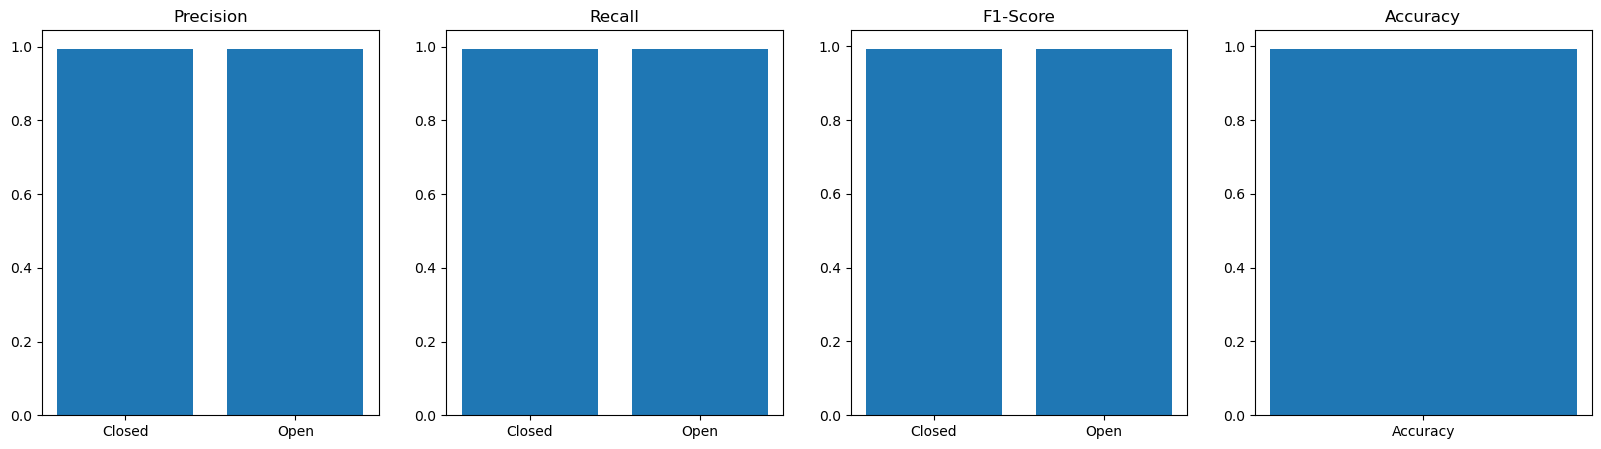

In [10]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Obtener las predicciones y los verdaderos valores
Y_pred = cnn_model.predict_generator(valid_data, steps=len(valid_data))
y_pred = np.argmax(Y_pred, axis=1)
y_true = valid_data.classes

# Calcular las métricas
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
accuracy = accuracy_score(y_true, y_pred)

# Graficar las métricas
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].bar(class_names, precision)
ax[0].set_title('Precision')
ax[1].bar(class_names, recall)
ax[1].set_title('Recall')
ax[2].bar(class_names, f1_score)
ax[2].set_title('F1-Score')
ax[3].bar(['Accuracy'], [accuracy])
ax[3].set_title('Accuracy')
plt.show()